In [ ]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete. Use files.upload() to upload data, files.download() to download results.")
else:
    print("Running in local environment")

<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/code_examples/example_01_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 02 Example 1: Basic 4D-STEM Calibration Workflow

This notebook demonstrates fundamental calibration techniques for 4D-STEM data using py4DSTEM.


# Calibration with py4DSTEM

## Overview
This notebook demonstrates how to load and calibrate 4D-STEM data using py4DSTEM. We'll use the Au reference standard (Diffraction SI_Au_calib.dm4) which is ideal for calibration because it contains known crystalline structures.

### What is calibration?
Calibration means establishing the relationship between pixel coordinates in your diffraction patterns and reciprocal space (k-space). Key calibration parameters include:
- **Origin**: The center position of the diffraction pattern
- **Pixel size**: The reciprocal space resolution (e.g., 1/nm per pixel)
- **Rotation/Ellipticity**: Corrections for detector tilt and distortion

### Key Learning Points
1. How to load experimental 4D-STEM data
2. Basic examination of calibration parameters
3. Manual calibration approaches
4. Using reference materials for precise calibration
5. Saving calibration parameters for future analysis

## Part 1: Load Libraries and Data

In [22]:
# Import necessary libraries
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

# Check py4DSTEM version
print(f"py4DSTEM version: {py4DSTEM.__version__}")

py4DSTEM version: 0.14.14


In [54]:
# Load the Au calibration reference dataset
# This is a small 4D-STEM dataset with known crystalline structures

filepath = '/Users/ginocangialosi/Documents/MSE 465/MATSCI465_GinoCangialosi/Week_02/assignments/raw_data/Diffraction SI_Au_Calib.dm4'

try:
    dataset_calib = py4DSTEM.io.import_file(filepath)
    print(f"✓ Dataset loaded successfully!")
    print(f"\nDataset information:")
    print(f"  Shape: {dataset_calib.shape} (order: Rx, Ry, Qx, Qy)")
    print(f"  Diffraction pattern size: {dataset_calib.shape[2:]} pixels")
    print(f"  Scan area: {dataset_calib.shape[0]} x {dataset_calib.shape[1]} pixels")
except FileNotFoundError:
    print(f"✗ File not found: {filepath}")
    print("Make sure SI_Au_calib.dm4 is in the raw_data folder")

✓ Dataset loaded successfully!

Dataset information:
  Shape: (20, 20, 256, 256) (order: Rx, Ry, Qx, Qy)
  Diffraction pattern size: (256, 256) pixels
  Scan area: 20 x 20 pixels


## Part 2: Examine Existing Calibration

In [55]:
# Check the current calibration metadata
# py4DSTEM stores calibration in the DataCube object

print("Current Calibration Information:")
print(f"\nData shape: {dataset_calib.data.shape}")
print(f"Data type: {dataset_calib.data.dtype}")
print(f"Min value: {dataset_calib.data.min()}")
print(f"Max value: {dataset_calib.data.max()}")
print(f"Mean value: {dataset_calib.data.mean():.2f}")

Current Calibration Information:

Data shape: (20, 20, 256, 256)
Data type: uint16
Min value: 0
Max value: 13
Mean value: 0.01


## Part 3: Visualize Raw Diffraction Pattern

Diffraction pattern shape: (256, 256)
Pattern min: 0, max: 8


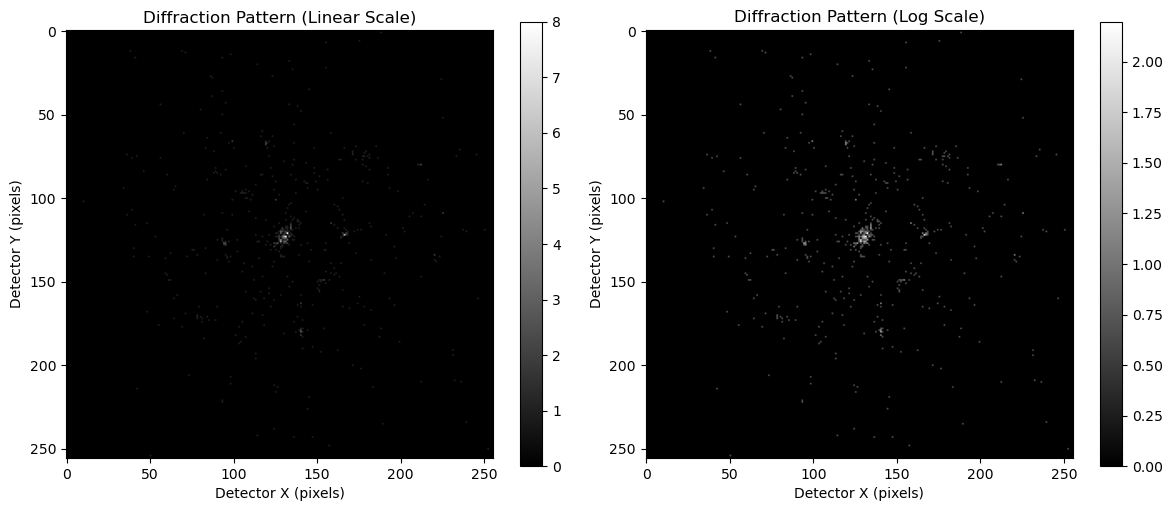


Pattern extracted from scan position (10, 10)


In [26]:
# Extract and display a diffraction pattern from the center of the scan
# Data layout: (Rx, Ry, Qx, Qy) → scan first, diffraction last

center_x = dataset_calib.shape[0] // 2
center_y = dataset_calib.shape[1] // 2

# Extract one diffraction pattern from center of scan
diffraction_pattern = dataset_calib.data[center_x, center_y, :, :]

print(f"Diffraction pattern shape: {diffraction_pattern.shape}")
print(f"Pattern min: {diffraction_pattern.min()}, max: {diffraction_pattern.max()}")

# Visualize the pattern
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Linear scale
im1 = axes[0].imshow(diffraction_pattern, cmap='gray')
axes[0].set_title('Diffraction Pattern (Linear Scale)')
axes[0].set_xlabel('Detector X (pixels)')
axes[0].set_ylabel('Detector Y (pixels)')
plt.colorbar(im1, ax=axes[0])

# Log scale (often better for seeing weak features)
im2 = axes[1].imshow(np.log1p(diffraction_pattern), cmap='gray')
axes[1].set_title('Diffraction Pattern (Log Scale)')
axes[1].set_xlabel('Detector X (pixels)')
axes[1].set_ylabel('Detector Y (pixels)')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"\nPattern extracted from scan position ({center_x}, {center_y})")

## Part 4: Determine Diffraction Pattern Center (Origin Calibration)

The origin is the center of the diffraction pattern, usually the zero-order (unscattered) beam position.

In [27]:
# For a symmetric detector, a simple estimate is the geometric center
origin_x = dataset_calib.shape[2] / 2.0
origin_y = dataset_calib.shape[3] / 2.0

print(f"Estimated origin (geometric center):")
print(f"  x-coordinate: {origin_x:.1f} pixels")
print(f"  y-coordinate: {origin_y:.1f} pixels")

# For more precise determination, you could:
# 1. Find the brightest pixel in diffraction patterns
# 2. Use the center of mass method
# 3. Use crystallographic Bragg spot detection

print(f"\nNote: More precise calibration would require analyzing")
print(f"multiple diffraction patterns and using crystallographic methods.")

Estimated origin (geometric center):
  x-coordinate: 128.0 pixels
  y-coordinate: 128.0 pixels

Note: More precise calibration would require analyzing
multiple diffraction patterns and using crystallographic methods.


## Part 5: Create Reciprocal Space Coordinate System

Map detector pixel coordinates to reciprocal space (k-space) values.

Reciprocal space calibration:
  Pixel size: 0.02 1/nm per pixel
  qx range: [-2.560, 2.540] 1/nm
  qy range: [-2.560, 2.540] 1/nm


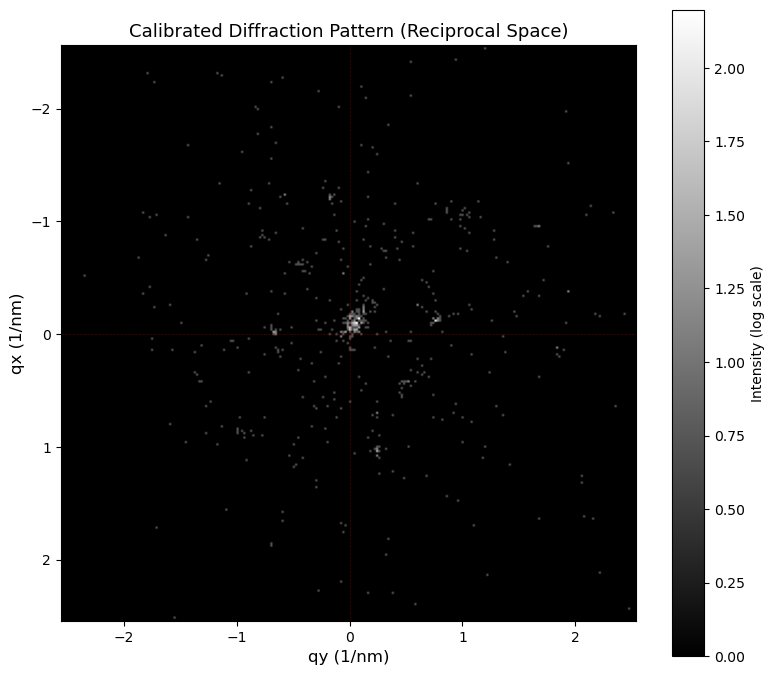

In [28]:
# Define reciprocal space calibration
# For a typical 4D-STEM experiment, the pixel size in reciprocal space
# depends on the experimental geometry

# Example values (these would be calibrated for your specific setup):
reciprocal_pixel_size = 0.02  # 1/nm per pixel (typical for 200kV STEM)

# Create coordinate arrays (centered at origin)
qx = (np.arange(dataset_calib.shape[2]) - origin_x) * reciprocal_pixel_size
qy = (np.arange(dataset_calib.shape[3]) - origin_y) * reciprocal_pixel_size

print(f"Reciprocal space calibration:")
print(f"  Pixel size: {reciprocal_pixel_size} 1/nm per pixel")
print(f"  qx range: [{qx.min():.3f}, {qx.max():.3f}] 1/nm")
print(f"  qy range: [{qy.min():.3f}, {qy.max():.3f}] 1/nm")

# Visualize the calibrated diffraction pattern
fig, ax = plt.subplots(1, 1, figsize=(8, 7))

im = ax.imshow(np.log1p(diffraction_pattern), 
               extent=[qy.min(), qy.max(), qx.max(), qx.min()],
               cmap='gray', origin='upper')
ax.set_xlabel('qy (1/nm)', fontsize=12)
ax.set_ylabel('qx (1/nm)', fontsize=12)
ax.set_title('Calibrated Diffraction Pattern (Reciprocal Space)', fontsize=13)
ax.axhline(y=0, color='r', linestyle='--', alpha=0.3, linewidth=0.5)
ax.axvline(x=0, color='r', linestyle='--', alpha=0.3, linewidth=0.5)
plt.colorbar(im, ax=ax, label='Intensity (log scale)')
plt.tight_layout()
plt.show()

## Part 6: Scan Area Calibration

Establish the relationship between scan pixel coordinates and real-space distance.

In [29]:
# Define the real-space pixel size for the scan area
# This depends on the microscope magnification and scan coil settings

# Example: assuming ~1 Angstrom per pixel (typical high-magnification STEM)
real_pixel_size = 0.1  # nanometers per pixel

# Create real-space coordinate arrays
# Data shape is (Rx, Ry, Qx, Qy), so scan dimensions are 0 and 1
rx = np.arange(dataset_calib.shape[0]) * real_pixel_size
ry = np.arange(dataset_calib.shape[1]) * real_pixel_size

print(f"Real-space (scan area) calibration:")
print(f"  Pixel size: {real_pixel_size} nm per pixel")
print(f"  Scan width (rx): {rx[-1]:.2f} nm")
print(f"  Scan height (ry): {ry[-1]:.2f} nm")
print(f"  Total scan area: {rx[-1]:.2f} × {ry[-1]:.2f} nm²")

Real-space (scan area) calibration:
  Pixel size: 0.1 nm per pixel
  Scan width (rx): 1.90 nm
  Scan height (ry): 1.90 nm
  Total scan area: 1.90 × 1.90 nm²


## Part 7: Visualize Integrated Signal

Create a simple real-space image by integrating the diffraction data.

Virtual image shape: (20, 20)
Virtual image min: 0, max: 1502


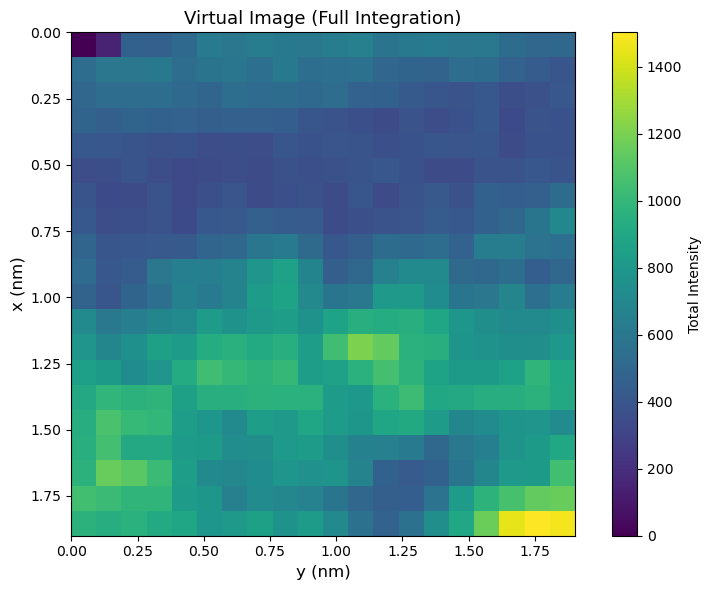

In [30]:
# Create a virtual diffraction detector by integrating over all diffraction angles
# Data shape is (Rx, Ry, Qx, Qy), so sum over diffraction dimensions (2, 3)

virtual_image = np.sum(dataset_calib.data, axis=(2, 3))

print(f"Virtual image shape: {virtual_image.shape}")
print(f"Virtual image min: {virtual_image.min()}, max: {virtual_image.max()}")

# Visualize the virtual image with calibrated axes
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

im = ax.imshow(virtual_image, extent=[ry[0], ry[-1], rx[-1], rx[0]], 
               cmap='viridis', origin='upper')
ax.set_xlabel('y (nm)', fontsize=12)
ax.set_ylabel('x (nm)', fontsize=12)
ax.set_title('Virtual Image (Full Integration)', fontsize=13)
plt.colorbar(im, ax=ax, label='Total Intensity')
plt.tight_layout()
plt.show()

## Part 8: Store Calibration Parameters

Save the calibration information for use in subsequent analysis.

In [47]:
# Create a calibration dictionary with all parameters
calibration_params = {
    'origin_x': origin_x,
    'origin_y': origin_y,
    'reciprocal_pixel_size': reciprocal_pixel_size,  # 1/nm per pixel
    'real_pixel_size': real_pixel_size,  # nm per pixel
    'diffraction_shape': dataset_calib.shape[2:],
    'scan_shape': dataset_calib.shape[:2],
}

print("\nCalibration Parameters Summary:")
print("=" * 50)
for key, value in calibration_params.items():
    print(f"{key:.<30} {value}")

# Save to a file for later use
import json
print(f"json version: {json.__version__}")
calib_file = '/Users/ginocangialosi/Documents/MSE 465/MATSCI465_GinoCangialosi/Week_02/code_examples/calibration_SI_Au.json'
print(calibration_params)

# Convert tuples to lists for JSON serialization
calib_to_save = calibration_params.copy()
calib_to_save['diffraction_shape'] = list(calib_to_save['diffraction_shape'])
calib_to_save['scan_shape'] = list(calib_to_save['scan_shape'])

with open(calib_file, 'w') as f:
    json.dump(calib_to_save, f, indent=4)

print(f"\n✓ Calibration saved to {calib_file}")


Calibration Parameters Summary:
origin_x...................... 128.0
origin_y...................... 128.0
reciprocal_pixel_size......... 0.02
real_pixel_size............... 0.1
diffraction_shape............. (256, 256)
scan_shape.................... (20, 20)
json version: 2.0.9
{'origin_x': 128.0, 'origin_y': 128.0, 'reciprocal_pixel_size': 0.02, 'real_pixel_size': 0.1, 'diffraction_shape': (256, 256), 'scan_shape': (20, 20)}

✓ Calibration saved to /Users/ginocangialosi/Documents/MSE 465/MATSCI465_GinoCangialosi/Week_02/code_examples/calibration_SI_Au.json


## Part 9: Load and Apply Calibration to New Data

Example of how to load saved calibration and apply it to another dataset.

In [46]:
# Example: How to use the saved calibration

# Load calibration
import json

with open(calib_file, 'r') as f:
    loaded_calib = json.load(f)

print("Loaded calibration parameters:")
print(json.dumps(loaded_calib, indent=2))

# This calibration can now be applied to similar datasets
# that were collected under the same microscope conditions

Loaded calibration parameters:
{
  "origin_x": 128.0,
  "origin_y": 128.0,
  "reciprocal_pixel_size": 0.02,
  "real_pixel_size": 0.1,
  "diffraction_shape": [
    256,
    256
  ],
  "scan_shape": [
    20,
    20
  ]
}


## Summary

Key takeaways from this calibration example:

1. **Loading Data**: py4DSTEM makes it easy to load .dm4 files with `import_file()`

2. **Origin Calibration**: The diffraction pattern center (origin) is the reference point for k-space

3. **Reciprocal Space Calibration**: Converting pixel coordinates to 1/nm requires the pixel size in reciprocal space

4. **Real-Space Calibration**: Similar process for converting scan pixels to nanometers

5. **Virtual Detectors**: By integrating over regions of the diffraction pattern, we can create various contrast images

6. **Calibration Storage**: Store parameters for reproducibility and consistency across experiments

### Next Steps:
- Use more sophisticated methods (e.g., Bragg spot detection) for precise origin calibration
- Implement ellipticity and rotation corrections
- Compare with reference crystal structures
- Apply calibration to quantitative analysis (strain, composition mapping, etc.)